# Movie reviews

This notebook takes you though a complete iteration of Machine Learning Assignment 1 - Movie reviews. The assignment details (including links to download the data) can be found [here](https://docs.google.com/document/d/1WGYw99e5q6j5V0Zrf2HveagU6URt_kVvdR8B9HYQ99E/edit?usp=sharing). 

In [1]:
# all imports and magic commands
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from my_measures import BinaryClassificationPerformance
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
%matplotlib inline

### IMPORTANT!!! Make sure you are using `BinaryClassificationPerformance` v1.02

In [2]:
help(BinaryClassificationPerformance)

Help on class BinaryClassificationPerformance in module my_measures:

class BinaryClassificationPerformance(builtins.object)
 |  BinaryClassificationPerformance(predictions, labels, desc, probabilities=None)
 |  
 |  Performance measures to evaluate the fit of a binary classification model, v1.02
 |  
 |  Methods defined here:
 |  
 |  __init__(self, predictions, labels, desc, probabilities=None)
 |      Initialize attributes: predictions-vector of predicted values for Y, labels-vector of labels for Y
 |  
 |  compute_measures(self)
 |      Compute performance measures defined by Flach p. 57
 |  
 |  img_indices(self)
 |      Get the indices of true and false positives to be able to locate the corresponding images in a list of image names
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the obj

# Function for feature building and extraction on natural language data

In [5]:
# function that takes raw data and completes all preprocessing required before model fits
def process_raw_data(fn, my_random_seed, test=False):
    # read and summarize data
    movie_data = pd.read_csv(fn, sep='\t')
    print("movie_data is:", type(movie_data))
    print("movie_data has", movie_data.shape[0], "rows and", movie_data.shape[1], "columns", "\n")
    print("the data types for each of the columns in movie_data:")
    print(movie_data.dtypes, "\n")
    print("the first 10 rows in movie_data:")
    print(movie_data.head(5))
    if (not test):
        print("The rate of 'good' movie reviews in the dataset: ")
        print(movie_data['sentiment'].mean())

    # vectorize Bag of Words from review text; as sparse matrix
    if (not test): # fit_transform()
        hv = HashingVectorizer(n_features=2 ** 17, alternate_sign=False)
        X_hv = hv.fit_transform(movie_data.review)
        fitted_transformations.append(hv)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    else: # transform() 
        X_hv = fitted_transformations[0].transform(movie_data.review)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    
    # http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html
    if (not test):
        transformer = TfidfTransformer()
        X_tfidf = transformer.fit_transform(X_hv)
        fitted_transformations.append(transformer)
    else:
        X_tfidf = fitted_transformations[1].transform(X_hv)
    
    # create additional quantitative features
    # features from Amazon.csv to add to feature set
    movie_data['word_count'] = movie_data['review'].str.split(' ').str.len()
    movie_data['punc_count'] = movie_data['review'].str.count("\.")

    X_quant_features = movie_data[["word_count", "punc_count"]]
    print("Look at a few rows of the new quantitative features: ")
    print(X_quant_features.head(10))
    
    # Combine all quantitative features into a single sparse matrix
    X_quant_features_csr = csr_matrix(X_quant_features)
    X_combined = hstack([X_tfidf, X_quant_features_csr])
    X_matrix = csr_matrix(X_combined) # convert to sparse matrix
    print("Size of combined bag of words and new quantitative variables matrix:")
    print(X_matrix.shape)
    
    # Create `X`, scaled matrix of features
    # feature scaling
    if (not test):
        sc = StandardScaler(with_mean=False)
        X = sc.fit_transform(X_matrix)
        fitted_transformations.append(sc)
        print(X.shape)
        y = movie_data['sentiment']
    else:
        X = fitted_transformations[2].transform(X_matrix)
        print(X.shape)
    
    # Create Training and Test Sets
    # enter an integer for the random_state parameter; any integer will work
    if (test):
        X_submission_test = X
        print("Shape of X_test for submission:")
        print(X_submission_test.shape)
        print('SUCCESS!')
        return(movie_data, X_submission_test)
    else: 
        X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = train_test_split(X, y, movie_data, test_size=0.2, random_state=my_random_seed)
        print("Shape of X_train and X_test:")
        print(X_train.shape)
        print(X_test.shape)
        print("Shape of y_train and y_test:")
        print(y_train.shape)
        print(y_test.shape)
        print("Shape of X_raw_train and X_raw_test:")
        print(X_raw_train.shape)
        print(X_raw_test.shape)
        print('SUCCESS!')
        return(X_train, X_test, y_train, y_test, X_raw_train, X_raw_test)

# Create training and test sets from function

In [6]:
# create an empty list to store any use of fit_transform() to transform() later
# it is a global list to store model and feature extraction fits
fitted_transformations = []

# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = process_raw_data(fn='moviereviews_train.tsv', my_random_seed=64)

print("Number of fits stored in `fitted_transformations` list: ")
print(len(fitted_transformations))

movie_data is: <class 'pandas.core.frame.DataFrame'>
movie_data has 25000 rows and 3 columns 

the data types for each of the columns in movie_data:
id           object
sentiment     int64
review       object
dtype: object 

the first 10 rows in movie_data:
       id  sentiment                                             review
0  5814_8          1  With all this stuff going down at the moment w...
1  2381_9          1  \The Classic War of the Worlds\" by Timothy Hi...
2  7759_3          0  The film starts with a manager (Nicholas Bell)...
3  3630_4          0  It must be assumed that those who praised this...
4  9495_8          1  Superbly trashy and wondrously unpretentious 8...
The rate of 'good' movie reviews in the dataset: 
0.5
Shape of HashingVectorizer X:
(25000, 131072)
Look at a few rows of the new quantitative features: 
   word_count  punc_count
0         433          20
1         158          16
2         378          20
3         379           8
4         367           9


# Fit (and tune) Various Models

### MODEL: ordinary least squares

In [7]:
from sklearn import linear_model
ols = linear_model.SGDClassifier(loss="squared_loss")
ols.fit(X_train, y_train)

ols_performance_train = BinaryClassificationPerformance(ols.predict(X_train), y_train, 'ols_train')
ols_performance_train.compute_measures()
print(ols_performance_train.performance_measures)

{'Pos': 10010, 'Neg': 9990, 'TP': 5324, 'TN': 4646, 'FP': 5344, 'FN': 4686, 'Accuracy': 0.4985, 'Precision': 0.4990626171728534, 'Recall': 0.5318681318681319, 'desc': 'ols_train'}


### MODEL: SVM, linear

In [10]:
from sklearn import linear_model
svm = linear_model.SGDClassifier()
svm.fit(X_train, y_train)

svm_performance_train = BinaryClassificationPerformance(svm.predict(X_train), y_train, 'svm_train')
svm_performance_train.compute_measures()
print(svm_performance_train.performance_measures)

{'Pos': 10010, 'Neg': 9990, 'TP': 10010, 'TN': 9990, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'svm_train'}


In [49]:
from sklearn.svm import LinearSVC
svc = LinearSVC(C = 1)
svc.fit(X_train, y_train)

svc_1 = LinearSVC(C = 100)
svc.fit(X_train, y_train)

svc_2 = LinearSVC(C = 10000)
svc.fit(X_train, y_train)

svc_3 = LinearSVC(C = 0.01)
svc.fit(X_train, y_train)

svc_4 = LinearSVC(C = 0.001)
svc.fit(X_train, y_train)

svc_5 = LinearSVC(C = 0.000000000001)
svc.fit(X_train, y_train)

svc_performance_train = BinaryClassificationPerformance(svc.predict(X_train), y_train, 'svc_train_C')
svc_performance_train.compute_measures()
print(svc_performance_train.performance_measures)

svc_performance_train_1 = BinaryClassificationPerformance(svc.predict(X_train), y_train, 'svc_train_C1')
svc_performance_train_1.compute_measures()
print(svc_performance_train_1.performance_measures)

svc_performance_train_2 = BinaryClassificationPerformance(svc.predict(X_train), y_train, 'svc_train_C2')
svc_performance_train_2.compute_measures()
print(svc_performance_train_2.performance_measures)

svc_performance_train_3 = BinaryClassificationPerformance(svc.predict(X_train), y_train, 'svc_train_C3')
svc_performance_train_3.compute_measures()
print(svc_performance_train_3.performance_measures)

svc_performance_train_4 = BinaryClassificationPerformance(svc.predict(X_train), y_train, 'svc_train_C4')
svc_performance_train_4.compute_measures()
print(svc_performance_train_4.performance_measures)

svc_performance_train_5 = BinaryClassificationPerformance(svc.predict(X_train), y_train, 'svc_train_C5')
svc_performance_train_5.compute_measures()
print(svc_performance_train_5.performance_measures)



{'Pos': 10010, 'Neg': 9990, 'TP': 10010, 'TN': 9990, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'svc_train_C'}
{'Pos': 10010, 'Neg': 9990, 'TP': 10010, 'TN': 9990, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'svc_train_C1'}
{'Pos': 10010, 'Neg': 9990, 'TP': 10010, 'TN': 9990, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'svc_train_C2'}
{'Pos': 10010, 'Neg': 9990, 'TP': 10010, 'TN': 9990, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'svc_train_C3'}
{'Pos': 10010, 'Neg': 9990, 'TP': 10010, 'TN': 9990, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'svc_train_C4'}
{'Pos': 10010, 'Neg': 9990, 'TP': 10010, 'TN': 9990, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'svc_train_C5'}


### MODEL: logistic regression

In [7]:
from sklearn import linear_model
lgs = linear_model.SGDClassifier(loss='log')
lgs.fit(X_train, y_train)

lgs_performance_train = BinaryClassificationPerformance(lgs.predict(X_train), y_train, 'lgs_train')
lgs_performance_train.compute_measures()
print(lgs_performance_train.performance_measures)

{'Pos': 10033, 'Neg': 9967, 'TP': 10033, 'TN': 9967, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'lgs_train'}


### MODEL: Naive Bayes

In [8]:
from sklearn.naive_bayes import MultinomialNB
nbs = MultinomialNB()
nbs.fit(X_train, y_train)

nbs_performance_train = BinaryClassificationPerformance(nbs.predict(X_train), y_train, 'nbs_train')
nbs_performance_train.compute_measures()
print(nbs_performance_train.performance_measures)

{'Pos': 10033, 'Neg': 9967, 'TP': 9633, 'TN': 9811, 'FP': 156, 'FN': 400, 'Accuracy': 0.9722, 'Precision': 0.9840637450199203, 'Recall': 0.9601315658327519, 'desc': 'nbs_train'}


### MODEL: Perceptron

In [9]:
from sklearn import linear_model
prc = linear_model.SGDClassifier(loss='perceptron')
prc.fit(X_train, y_train)

prc_performance_train = BinaryClassificationPerformance(prc.predict(X_train), y_train, 'prc_train')
prc_performance_train.compute_measures()
print(prc_performance_train.performance_measures)

{'Pos': 10033, 'Neg': 9967, 'TP': 10033, 'TN': 9967, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'prc_train'}


### MODEL: Ridge Regression Classifier

In [10]:
from sklearn import linear_model
rdg = linear_model.RidgeClassifier()
rdg.fit(X_train, y_train)

rdg_performance_train = BinaryClassificationPerformance(rdg.predict(X_train), y_train, 'rdg_train')
rdg_performance_train.compute_measures()
print(rdg_performance_train.performance_measures)

{'Pos': 10033, 'Neg': 9967, 'TP': 10033, 'TN': 9967, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'rdg_train'}


### MODEL: Random Forest Classifier

In [11]:
from sklearn.ensemble import RandomForestClassifier
rdf = RandomForestClassifier(max_depth=2, random_state=0)
rdf.fit(X_train, y_train)

rdf_performance_train = BinaryClassificationPerformance(rdf.predict(X_train), y_train, 'rdf_train')
rdf_performance_train.compute_measures()
print(rdf_performance_train.performance_measures)

/home/ec2-user/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


{'Pos': 10033, 'Neg': 9967, 'TP': 5223, 'TN': 6699, 'FP': 3268, 'FN': 4810, 'Accuracy': 0.5961, 'Precision': 0.615121893769874, 'Recall': 0.5205820791388418, 'desc': 'rdf_train'}


### ROC plot to compare performance of various models and fits

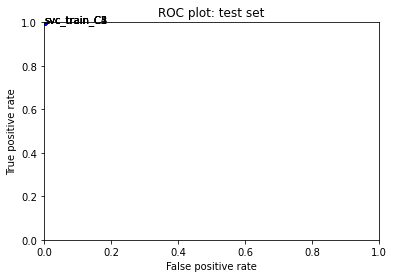

In [47]:
fits = [svc_performance_train_1, svc_performance_train_2, svc_performance_train_3, svc_performance_train_4, svc_performance_train_5]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

### looking at reviews based on their classification

Let's say we decide that Ordinary Least Squares (OLS) Regression is the best model for generalization. Let's take a look at some of the reviews and try to make a (subjective) determination of whether it's generalizing well. 

In [38]:
ols_predictions = ols.predict(X_train)

### let's look at some false positives:

In [24]:
# false positives

print("Examples of false positives:")

import random, time

for i in range(0, len(ols_predictions)):
    if (ols_predictions[i] == 1):
        if (X_raw_train.iloc[i]['sentiment'] == 0):
            if (random.uniform(0, 1) < 0.05): # to print only 5% of the false positives
                print(i)
                print(X_raw_train.iloc[i]['review'])
                print('* * * * * * * * * ')


Examples of false positives:
322
Every now and again you hear radio djs inviting listeners to nominate movies that the listener can't stand or never watched all the way through. This is the movie that I think of...days later.<br /><br />It's got something to do with a play by Shakespeare. Not sure, but I think I bailed on this movie some 20 odd minutes into it...think I realised that my toenails wouldn't clip themselves, and they were looking at me imploringly to get cut.<br /><br />This movie just seemed boring and pretentious to me.<br /><br />Even though this is the first movie I've given such a low score to (which I've actually attempted to watch), I wouldn't want to put you off other movies by it's English director, Peter Greenaway. I remember thinking that his \The cook, the thief, his wife and her lover\" was a truly great British film even though its content was at times stomach churning-a brilliant movie, but I can understand why people would balk at seeing it.<br /><br />Anot

1509
In the first 20 minutes, every cliche possible was trotted out by the hack writer and director. There was the NTSB primary investigator with the tortured family life; the politically-tortured NTSB board member played by [I can kill ANY TV] Ted McGinley; the tortured father of a crash victim; and the torturing sleazy ambulance-chasing lawyer.<br /><br />Hollywood still has no concept of the fragility of aircraft. The crashed plane was a 737 and it was mostly sitting on the ground like a hippo who decided to take a nap. The first third of the fuselage was intact, the rear half of the plane was intact and the debris field showed no wings or engines. Most of the people should have walked away in light of how many people survived that plane that got shredded in Iowa after it lost its hydraulics. Most of this TV plane wasn't even burned.<br /><br />It reminded me of the scene in \Air Force One\" where the 747 hits the water and then skips along like it's made of inch-thick steel.<br /><

4039
The director, outfitted in chains and leather, warned the audience at the SF Frameline Film Festival Friday night that we were about to see an \experiental\" film. Experimental? Leave the video camera on the back seat of the car, let the tape roll and edit in all the pointless dreck within eyesight. A meandering pastiche road show manqué that starts nowhere and takes the audience no place. The gratuitous violence that opens the movie drove more than one patron from the Castro theater. I would have left, too, but my cine-buddy needed a ride home and has this thing about seeing even the worse merde through to the end. By the time the lights came up the audience had thinned considerably. Tepid applause. Pro forma questions of the director who seemed pleased with the product. Avoid this film!"
* * * * * * * * * 
4078
This film is \riveting\" but in much the same way a car crash is riveting. It's hard to look away. Overall, this film is nothing more than an incredibly irresponsible soc

5959
John Huston's Wise Blood was a more horrifying misrepresentation of Flannery O'Connor's book than I could have imagined. From the utterly terrible acting performances (and don't you, \Oh that was done on purpose, you just don't get it\" me!) to the musical score that was more suited to an episode of Rockford Files, this film was revolting. I viewed it with no ill-will at the outset, and, in fact, expected a pleasant experience. But the misrepresentation of the southern characters, from the ridiculously fraudulent southern drawl to the lilting, comedic way their faith was portrayed, was inexcusable. Right down to it's end, which was completely devoid of any character sentiment, it failed in every place that O'Connor's book shined and resonated. The actors portraying the \"southern\" policemen may as well have been eating smothered hot-dogs from NYC street stands and quoting Godfather. The one redeeming acting performance was Ned Beatty's lively and dead-on representation of Hoover 

8542
This movie proves that you can't judge a movie by the awesome artwork on the DVD cover. It also goes to show that you should learn more about a movie before you buy it (or get it for someone at Christmas). The beginning of this movie actually looks somewhat promising. Well, until you meet the characters. Pumpkin Jack (the old guy from down the street) brings the college co-eds a book full of witch's spells that he leaves at their annual haunted house (where the movie takes place). After that there is some drinking, fighting, and soft core porn. Then the action of the movie finally takes place after over an hour.<br /><br />Overall, Hallow's End was predictable, unsuspensful, and reminiscent of a soft-core porn. This movie is probably best viewed with a group of friends who have nothing better to do, as it is a good movie to make fun of. And for first-time viewers, it is really fun making predictions of the order of people who die.
* * * * * * * * * 
8658
It a bit peculiar that a s

A very good story for a film which if done properly would be quite interesting, but where the hell is the ending to this film?<br /><br />In fact, what is the point of it?<br /><br />The scenes zip through so quick that you felt you were not part of the film emotionally, and the feeling of being detached from understanding the storyline.<br /><br />The performances of the cast are questionable, if not believable.<br /><br />Did I miss the conclusion somewhere in the film? I guess we have to wait for the sequel.<br /><br />
* * * * * * * * * 
10673
Just a stilted rip-off of the infinitely better \Murder, She Wrote\", it is absolutely amazing that this poorly-written garbage lasted for a full eight years. I'm sure most of the people who watched this unentertaining crap were in their sixties and seventies and just tuned in because they had nothing better to do, or simply remembered its star from the old Dick Van Dyke Show. Van Dyke, who only had a decent career in the 1960s, never was muc

12503
In this strangely-lackadaisical apocalypse, the world suffers from a dual plague of zombies and vampires, but no one seems to be too worried about it in this Grade-Z film which bares less resemblance to Sheridan Le Fanu's famous short novel than my mother's lasagna recipe. Bored attendants still run gas stations and doctors still make house calls and helpful police officers still show up with radiator fluid just when you need it. The plot, and I use that term loosely, involves a father and a daughter trying to rendevous with \the general,\" whose daughter is missing, at a church to kill a vampire who, very conveniently, happens to be traveling with the father and daughter. I must confess that a moment or two of genuine humor can be found between vast stretches of unintentional humor. The film also boasts just enough nudity to keep a boy of fourteen interested. Anyone older beware."
* * * * * * * * * 
12525
Witty. Quirky. Genuine. Surreal. Butterfly wings? One could ask what all o

14795
A perfect little atrocity...I doubt if a single shot lasted for more then the reglamentary-MTV 4.4 seconds. Woeful casting, worse even than in Kusminsky's version (a reminder: he managed to miscast Juliet Binoche and Ralph Feinnnes). But, hey-the rich got what they deserved. Dark and brooding Heathcliff reduced to the state of a golden-locked angel, frail and angellic Catherine presented as a chubby, melon-breasted heffer, meek and weak Linton is a peeping tom, and innocent Isabel becomes Sara Michelle-Gellar's character from Cruel Intentions. 15-year old Eddie Bauer and Abercrombie and Fitch donners-take notice. This thing was made for you. It is an hour-and-a-half long music video where everything is given to you; you are saved from the uncomfortable necessity of not even trying to understand the complexity of the characters, but even from initial shock at their actions. The actors tried, but, as I stated before, they were miscasted. Decent photography, but editing is on the le

17564
This is the most saccharine romance I ever sat through. The perfect film for an idle housewife in kerchief, housedress, and ostrich-trimmed high-heeled mules to watch in the afternoon, lying on the couch eating bonbons. In fact, bonbons play a prominent role in the movie.<br /><br />The only reason I was able to watch to the end, is that I finally was able to gaze at Keanu Reeves' dreamy face in almost every scene. In most of his films, he moves too fast to get a good look. The only rapid action in this show is Giancarlo Giannini waving his hands with Latin emotionality - more Italian than Mexican, really. <br /><br />The dialog is as stiff as wood. Unfortunately, no bodices are ripped - the hero is disgracefully perfect-mannered and mild. The aristocratic warm-blooded old-world family cliche is as old as the hills. What does it matter if they are Irish or Italian or Mexican? This is a fairy story.<br /><br />I knew before the titles finished running that this would not be the mo

---

# <span style="color:red">WARNING: Don't look at test set performance too much!</span>

---

The following cells show performance on your test set. Do not look at this too often! 

# Look at performance on the test set

### MODEL: ordinary least squares

In [15]:
ols_performance_test = BinaryClassificationPerformance(ols.predict(X_test), y_test, 'ols_test')
ols_performance_test.compute_measures()
print(ols_performance_test.performance_measures)

{'Pos': 2467, 'Neg': 2533, 'TP': 1430, 'TN': 1126, 'FP': 1407, 'FN': 1037, 'Accuracy': 0.5112, 'Precision': 0.5040535777229468, 'Recall': 0.5796513984596676, 'desc': 'ols_test'}


### MODEL: SVM, linear

In [16]:
svm_performance_test = BinaryClassificationPerformance(svm.predict(X_test), y_test, 'svm_test')
svm_performance_test.compute_measures()
print(svm_performance_test.performance_measures)

{'Pos': 2467, 'Neg': 2533, 'TP': 2035, 'TN': 2097, 'FP': 436, 'FN': 432, 'Accuracy': 0.8264, 'Precision': 0.8235532173209227, 'Recall': 0.8248885285772193, 'desc': 'svm_test'}


In [48]:
svc_performance_test = BinaryClassificationPerformance(svc.predict(X_test), y_test, 'svc_test_C')
svc_performance_test.compute_measures()
print(svc_performance_test.performance_measures)

svc_performance_test_1 = BinaryClassificationPerformance(svc.predict(X_test), y_test, 'svc_test_C1')
svc_performance_test_1.compute_measures()
print(svc_performance_test_1.performance_measures)

svc_performance_test_2 = BinaryClassificationPerformance(svc.predict(X_test), y_test, 'svc_test_C2')
svc_performance_test_2.compute_measures()
print(svc_performance_test_2.performance_measures)

svc_performance_test_3 = BinaryClassificationPerformance(svc.predict(X_test), y_test, 'svc_test_C3')
svc_performance_test_3.compute_measures()
print(svc_performance_test_3.performance_measures)

svc_performance_test_4 = BinaryClassificationPerformance(svc.predict(X_test), y_test, 'svc_test_C4')
svc_performance_test_4.compute_measures()
print(svc_performance_test_4.performance_measures)

svc_performance_test_5 = BinaryClassificationPerformance(svc.predict(X_test), y_test, 'svc_test_C5')
svc_performance_test_5.compute_measures()
print(svc_performance_test_5.performance_measures)

{'Pos': 2490, 'Neg': 2510, 'TP': 2159, 'TN': 2100, 'FP': 410, 'FN': 331, 'Accuracy': 0.8518, 'Precision': 0.8404048267808486, 'Recall': 0.8670682730923694, 'desc': 'svc_test_C'}
{'Pos': 2490, 'Neg': 2510, 'TP': 2159, 'TN': 2100, 'FP': 410, 'FN': 331, 'Accuracy': 0.8518, 'Precision': 0.8404048267808486, 'Recall': 0.8670682730923694, 'desc': 'svc_test_C1'}
{'Pos': 2490, 'Neg': 2510, 'TP': 2159, 'TN': 2100, 'FP': 410, 'FN': 331, 'Accuracy': 0.8518, 'Precision': 0.8404048267808486, 'Recall': 0.8670682730923694, 'desc': 'svc_test_C2'}
{'Pos': 2490, 'Neg': 2510, 'TP': 2159, 'TN': 2100, 'FP': 410, 'FN': 331, 'Accuracy': 0.8518, 'Precision': 0.8404048267808486, 'Recall': 0.8670682730923694, 'desc': 'svc_test_C3'}
{'Pos': 2490, 'Neg': 2510, 'TP': 2159, 'TN': 2100, 'FP': 410, 'FN': 331, 'Accuracy': 0.8518, 'Precision': 0.8404048267808486, 'Recall': 0.8670682730923694, 'desc': 'svc_test_C4'}
{'Pos': 2490, 'Neg': 2510, 'TP': 2159, 'TN': 2100, 'FP': 410, 'FN': 331, 'Accuracy': 0.8518, 'Precision': 

### MODEL: logistic regression

In [17]:
lgs_performance_test = BinaryClassificationPerformance(lgs.predict(X_test), y_test, 'lgs_test')
lgs_performance_test.compute_measures()
print(lgs_performance_test.performance_measures)

{'Pos': 2467, 'Neg': 2533, 'TP': 2041, 'TN': 2093, 'FP': 440, 'FN': 426, 'Accuracy': 0.8268, 'Precision': 0.822652156388553, 'Recall': 0.8273206323469802, 'desc': 'lgs_test'}


### MODEL: Naive Bayes

In [18]:
nbs_performance_test = BinaryClassificationPerformance(nbs.predict(X_test), y_test, 'nbs_test')
nbs_performance_test.compute_measures()
print(nbs_performance_test.performance_measures)

{'Pos': 2467, 'Neg': 2533, 'TP': 1768, 'TN': 1907, 'FP': 626, 'FN': 699, 'Accuracy': 0.735, 'Precision': 0.7385129490392648, 'Recall': 0.7166599108228617, 'desc': 'nbs_test'}


### MODEL: Perceptron

In [19]:
prc_performance_test = BinaryClassificationPerformance(prc.predict(X_test), y_test, 'prc_test')
prc_performance_test.compute_measures()
print(prc_performance_test.performance_measures)

{'Pos': 2467, 'Neg': 2533, 'TP': 2071, 'TN': 2084, 'FP': 449, 'FN': 396, 'Accuracy': 0.831, 'Precision': 0.8218253968253968, 'Recall': 0.8394811511957844, 'desc': 'prc_test'}


### MODEL: Ridge Regression Classifier

In [20]:
rdg_performance_test = BinaryClassificationPerformance(rdg.predict(X_test), y_test, 'rdg_test')
rdg_performance_test.compute_measures()
print(rdg_performance_test.performance_measures)

{'Pos': 2467, 'Neg': 2533, 'TP': 2106, 'TN': 2101, 'FP': 432, 'FN': 361, 'Accuracy': 0.8414, 'Precision': 0.8297872340425532, 'Recall': 0.853668423186056, 'desc': 'rdg_test'}


### MODEL: Random Forest Classifier

In [21]:
rdf_performance_test = BinaryClassificationPerformance(rdf.predict(X_test), y_test, 'rdf_test')
rdf_performance_test.compute_measures()
print(rdf_performance_test.performance_measures)

{'Pos': 2467, 'Neg': 2533, 'TP': 1253, 'TN': 1725, 'FP': 808, 'FN': 1214, 'Accuracy': 0.5956, 'Precision': 0.6079573022804464, 'Recall': 0.5079043372517228, 'desc': 'rdf_test'}


### ROC plot to compare performance of various models and fits

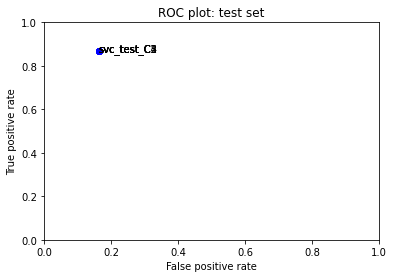

In [45]:
fits = [svc_performance_test, svc_performance_test_1, svc_performance_test_2, svc_performance_test_3, svc_performance_test_4, svc_performance_test_5]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

---

# <span style="color:red">SUBMISSION</span>

---

In [23]:
# read in test data for submission
# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
raw_data, X_test_submission = process_raw_data(fn='/home/ec2-user/data/moviereviews_test.tsv', my_random_seed=74, test=True)
print("Number of rows in the submission test set (should be 25,000): ")

movie_data is: <class 'pandas.core.frame.DataFrame'>
movie_data has 25000 rows and 2 columns 

the data types for each of the columns in movie_data:
id        object
review    object
dtype: object 

the first 10 rows in movie_data:
         id                                             review
0  12311_10  Naturally in a film who's main themes are of m...
1    8348_2  This movie is a disaster within a disaster fil...
2    5828_4  All in all, this is a movie for kids. We saw i...
3    7186_2  Afraid of the Dark left me with the impression...
4   12128_7  A very accurate depiction of small time mob li...
Shape of HashingVectorizer X:
(25000, 131072)
Look at a few rows of the new quantitative features: 
   word_count  punc_count
0         131           5
1         169          15
2         176          18
3         112           5
4         133           8
5         331          20
6         121          18
7         230          22
8          59           3
9         224          14
Size

---

Choose a <span style="color:red">*single*</span> model for your submission. In this code, I am choosing the Ordinary Least Squares model fit, which is in the `ols` object. But you should choose the model that is performing the best for you! 

In [24]:
# store the id from the raw data
my_submission = pd.DataFrame(raw_data["id"])
# concatenate predictions to the id
my_submission["prediction"] = ols.predict(X_test_submission)
# look at the proportion of positive predictions
print(my_submission['prediction'].mean())

0.5596


In [25]:
raw_data.head()

,id,review,word_count,punc_count
0,12311_10,Naturally in a film who's main themes are of m...,131,5
1,8348_2,This movie is a disaster within a disaster fil...,169,15
2,5828_4,"All in all, this is a movie for kids. We saw i...",176,18
3,7186_2,Afraid of the Dark left me with the impression...,112,5
4,12128_7,A very accurate depiction of small time mob li...,133,8


In [26]:
my_submission.head()

,id,prediction
0,12311_10,1
1,8348_2,1
2,5828_4,1
3,7186_2,1
4,12128_7,0


In [27]:
my_submission.shape

(25000, 2)

In [28]:
# export submission file as pdf
# CHANGE FILE PATH: 
my_submission.to_csv('/home/ec2-user/data/moviereviews_submission.csv', index=False)

# Submit to Canvas: 1) the CSV file that was written in the previous cell and 2) the url to the repository (GitHub or other) that contains your code and documentation